<a href="https://colab.research.google.com/github/antaripg/deep-learning-notebooks/blob/main/Classification_with_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Tue Jun  8 05:52:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive

drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


### Classification with Multilayer Perceptron (MLP)

In [ ]:
# Importing the necessary Libraries
import os
import time
import tqdm
import torch
import pickle
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

print(torch.__version__)

savePath = '/content/drive/MyDrive/Visual_Computing_and_Deep_Learning/MLP_CIFAR10_output/'
if not os.path.isdir(savePath):
  os.mkdir(savePath)

1.8.1+cu101


### Loading the saved Features

In [ ]:
pickle_files_dict = { 'test_Feats':' ', 'test_Labels':' ', 'train_Feats':' ', 'train_Labels':' '}
pickle_files_dict['test_Feats'] = '/content/drive/MyDrive/Visual_Computing_and_Deep_Learning/testFeats.pkl'
pickle_files_dict['test_Labels'] = '/content/drive/MyDrive/Visual_Computing_and_Deep_Learning/testLabel.pkl'
pickle_files_dict['train_Feats'] = '/content/drive/MyDrive/Visual_Computing_and_Deep_Learning/trainFeats.pkl'
pickle_files_dict['train_Labels'] = '/content/drive/MyDrive/Visual_Computing_and_Deep_Learning/trainLabel.pkl'

In [ ]:
# Loading the saved features
with open(pickle_files_dict['train_Feats'], "rb") as f:
    trainFeats = pickle.load(f)
with open(pickle_files_dict['train_Labels'], "rb") as f:
    trainLabel = pickle.load(f)

with open(pickle_files_dict['test_Feats'], "rb") as f:
    testFeats = pickle.load(f)
with open(pickle_files_dict['test_Labels'], "rb") as f:
    testLabel = pickle.load(f)

print('Finished loading saved feature matrices from the disk!')



Finished loading saved feature matrices from the disk!


In [ ]:
print(trainLabel.shape[0],trainFeats.__len__(),trainLabel[1])

50000 50000 9


### One hot Coded Labels

In [ ]:
# Generating one hot enocded vectors
n_classes = 10
trainLabel2 = np.zeros((len(trainLabel), n_classes))
testLabel2 = np.zeros((len(testLabel), n_classes))

for d1 in range(trainLabel.shape[0]):
  trainLabel2[d1, trainLabel[d1]] = 1
for d2 in range(testLabel.shape[0]):
  testLabel2[d2, testLabel[d2]] = 1

### Checking for GPU

In [ ]:
# Checking availability of GPU
use_gpu =torch.cuda.is_available()
if use_gpu:
  print("GPU is available")
  device = "cuda"
  pinMem = True
else:
  print('GPU is not available')
  device = "cpu"
  pinMem  = False

GPU is available


### Dataset Preparation

In [ ]:
# Creating pytorch dataset from the feature matrices
trainDataset = TensorDataset(torch.from_numpy(trainFeats), torch.from_numpy(trainLabel2))
testDataset = TensorDataset(torch.from_numpy(testFeats), torch.from_numpy(testLabel2))

# Creating a DataLoader
trainLoader = DataLoader(trainDataset, batch_size = 64, shuffle= True, num_workers=1, pin_memory= pinMem)
testLoader = DataLoader(testDataset, batch_size = 64, num_workers= 1, pin_memory= pinMem)

### Defining the Network Structure

In [ ]:
class mlp(nn.Module):
  def __init__(self, n_channels):
    super(mlp, self).__init__()
    self.L1 = nn.Linear(n_channels, 6) # mapping the input features to the hidden layer
    self.L2 = nn.Linear(6, 10) # Mapping the hidden layer to the output
  def forward(self, x):
    x = self.L1(x) # Feed Forward
    x = F.relu(x)  # ReLU non-linear function
    x = self.L2(x) # Feed-Forward
    x = F.softmax(x) # Softmax non-linear function
    return x

### Defining function for training the network

In [ ]:
# Defining the training routine

def train_model(model, criterion, num_epochs, learning_rate):
  start = time.time()
  train_loss = [] # list for savign the loss per epoch
  train_acc = []
  tempLabels = []

  for epoch in range(num_epochs):
    epochStartTime = time.time()
    print('Epoch {}/{}'.format(epoch, num_epochs -1 ))

    running_loss = 0.0
    # Loading data in batches
    batch = 0
    for data in tqdm.notebook.tqdm(trainLoader):
      inputs, labels = data

      inputs, labels = inputs.float().to(device), labels.float().to(device)

      # Initializing model gradients to zero for each batch
      model.zero_grad()
      # Data feed-forward through the network
      outputs = model(inputs)
      # Predicted class is the one with the max probs
      _, preds = torch.max(outputs.data, 1)
      # Finfing MSE Loss
      loss = criterion(outputs, labels)
      #Accumulating the loss for each
      running_loss += loss.item()
      # Backpropagating the error
      if batch == 0:
        totalLoss = loss
        totalPreds = preds
        tempLabels = labels.data.cpu()
        batch += 1
      else:
        totalLoss += loss
        totalPreds = torch.cat((totalPreds, preds), 0)
        tempLabels = torch.cat((tempLabels, labels.data.cpu()), 0)
        batch += 1

    totalLoss = totalLoss/batch
    totalLoss.backward()

    # Updating the model parameters
    for f in model.parameters():
      f.data.sub_(f.grad.data * learning_rate)

    epoch_loss = running_loss / 50000 # Total loss for one epoch
    train_loss.append(epoch_loss) # Saving the loss over epoch for plotting the graph

    # Accuracy per epoch
    tempLabels = tempLabels.numpy()
    _, totalLabels = np.where(tempLabels == 1)
    epoch_acc = np.sum(np.equal(totalPreds.cpu().numpy(), np.array(totalLabels))) / 50000.0
    train_acc.append(epoch_acc * 100)

    print('Epoch loss: {:.6f}'.format(epoch_loss))
    print('Epoch Accuracy : {:.4f}'.format(epoch_acc * 100))
    epochTimeEnd = time.time() - epochStartTime
    print('Epoch complete in {:.0f} minutes {:.0f} seconds'.format( epochTimeEnd // 60, epochTimeEnd % 60))
    print('-' * 25)

    # Plotting Loss vs Epochs
    fig1 = plt.figure(1)
    plt.plot(range(epoch+1), train_loss, 'r--', label = 'train')
    if epoch == 0:
      plt.legend(loc = 'upper right')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.title('Plot of training vs epochs')
    fig1.savefig(savePath+'mlp_loss.png')

    fig2 = plt.figure(2)
    plt.plot(range(epoch + 1), train_acc, 'g--', label = 'train')
    if epoch == 0:
      plt.legend(loc = 'upper left')
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      plt.title('Plot of accuracy vs epochs')
    fig2.savefig(savePath+'accPlot.png')

  time_elapsed = time.time() - start
  print("Training complete in: {:0f} minutes {:0f} seconds".format(time_elapsed // 60, time_elapsed % 60))

  return model



### Model initilization and training

Epoch 0/299


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.



Epoch loss: 0.001414
Epoch Accuracy : 10.0000
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 1/299



Epoch loss: 0.001413
Epoch Accuracy : 10.0000
Epoch complete in 0 minutes 2 seconds
-------------------------
Epoch 2/299



Epoch loss: 0.001413
Epoch Accuracy : 10.0000
Epoch complete in 0 minutes 2 seconds
-------------------------
Epoch 3/299



Epoch loss: 0.001412
Epoch Accuracy : 10.0000
Epoch complete in 0 minutes 2 seconds
-------------------------
Epoch 4/299



Epoch loss: 0.001412
Epoch Accuracy : 9.9960
Epoch complete in 0 minutes 2 seconds
-------------------------
Epoch 5/299



Epoch loss: 0.001412
Epoch Accuracy : 10.0320
Epoch complete in 0 minutes 2 seconds
-------------------------
Epoch 6/299



Epoch loss: 0.001411
Epoch Accuracy : 10.1200
Epoch complete in 0 minutes 2 seconds
-------------------------
Epoch 7/299



Epoch loss: 0.001411
Epoch Accuracy : 10.2540
Epoch complete in 0 minutes 2 seconds
-------------------------
Epoch 8/299



Epoch loss: 0.001411
Epoch Accuracy : 10.5360
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 9/299



Epoch loss: 0.001410
Epoch Accuracy : 10.8160
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 10/299



Epoch loss: 0.001410
Epoch Accuracy : 11.0340
Epoch complete in 0 minutes 2 seconds
-------------------------
Epoch 11/299



Epoch loss: 0.001410
Epoch Accuracy : 11.2480
Epoch complete in 0 minutes 2 seconds
-------------------------
Epoch 12/299



Epoch loss: 0.001410
Epoch Accuracy : 11.4980
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 13/299



Epoch loss: 0.001410
Epoch Accuracy : 11.8680
Epoch complete in 0 minutes 2 seconds
-------------------------
Epoch 14/299



Epoch loss: 0.001410
Epoch Accuracy : 12.4200
Epoch complete in 0 minutes 2 seconds
-------------------------
Epoch 15/299



Epoch loss: 0.001409
Epoch Accuracy : 12.9580
Epoch complete in 0 minutes 2 seconds
-------------------------
Epoch 16/299



Epoch loss: 0.001409
Epoch Accuracy : 13.6300
Epoch complete in 0 minutes 2 seconds
-------------------------
Epoch 17/299



Epoch loss: 0.001409
Epoch Accuracy : 14.1460
Epoch complete in 0 minutes 2 seconds
-------------------------
Epoch 18/299



Epoch loss: 0.001409
Epoch Accuracy : 14.7680
Epoch complete in 0 minutes 2 seconds
-------------------------
Epoch 19/299



Epoch loss: 0.001409
Epoch Accuracy : 15.2120
Epoch complete in 0 minutes 2 seconds
-------------------------
Epoch 20/299



Epoch loss: 0.001409
Epoch Accuracy : 15.5260
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 21/299



Epoch loss: 0.001409
Epoch Accuracy : 15.7580
Epoch complete in 0 minutes 2 seconds
-------------------------
Epoch 22/299



Epoch loss: 0.001409
Epoch Accuracy : 15.9500
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 23/299



Epoch loss: 0.001408
Epoch Accuracy : 16.0840
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 24/299



Epoch loss: 0.001408
Epoch Accuracy : 16.1740
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 25/299



Epoch loss: 0.001408
Epoch Accuracy : 16.2140
Epoch complete in 0 minutes 2 seconds
-------------------------
Epoch 26/299



Epoch loss: 0.001408
Epoch Accuracy : 16.2960
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 27/299



Epoch loss: 0.001408
Epoch Accuracy : 16.3360
Epoch complete in 0 minutes 2 seconds
-------------------------
Epoch 28/299



Epoch loss: 0.001408
Epoch Accuracy : 16.3600
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 29/299



Epoch loss: 0.001408
Epoch Accuracy : 16.3720
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 30/299



Epoch loss: 0.001408
Epoch Accuracy : 16.3120
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 31/299



Epoch loss: 0.001408
Epoch Accuracy : 16.3060
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 32/299



Epoch loss: 0.001408
Epoch Accuracy : 16.2080
Epoch complete in 0 minutes 2 seconds
-------------------------
Epoch 33/299



Epoch loss: 0.001408
Epoch Accuracy : 16.1420
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 34/299



Epoch loss: 0.001408
Epoch Accuracy : 16.0280
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 35/299



Epoch loss: 0.001408
Epoch Accuracy : 15.9460
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 36/299



Epoch loss: 0.001407
Epoch Accuracy : 15.8500
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 37/299



Epoch loss: 0.001407
Epoch Accuracy : 15.7900
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 38/299



Epoch loss: 0.001407
Epoch Accuracy : 15.6860
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 39/299



Epoch loss: 0.001407
Epoch Accuracy : 15.6300
Epoch complete in 0 minutes 2 seconds
-------------------------
Epoch 40/299



Epoch loss: 0.001407
Epoch Accuracy : 15.5440
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 41/299



Epoch loss: 0.001407
Epoch Accuracy : 15.4860
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 42/299



Epoch loss: 0.001407
Epoch Accuracy : 15.4280
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 43/299



Epoch loss: 0.001407
Epoch Accuracy : 15.3640
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 44/299



Epoch loss: 0.001407
Epoch Accuracy : 15.2920
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 45/299



Epoch loss: 0.001407
Epoch Accuracy : 15.2640
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 46/299



Epoch loss: 0.001407
Epoch Accuracy : 15.2380
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 47/299



Epoch loss: 0.001407
Epoch Accuracy : 15.2060
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 48/299



Epoch loss: 0.001407
Epoch Accuracy : 15.1840
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 49/299



Epoch loss: 0.001407
Epoch Accuracy : 15.1740
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 50/299



Epoch loss: 0.001407
Epoch Accuracy : 15.1640
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 51/299



Epoch loss: 0.001407
Epoch Accuracy : 15.1500
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 52/299



Epoch loss: 0.001407
Epoch Accuracy : 15.1400
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 53/299



Epoch loss: 0.001407
Epoch Accuracy : 15.1200
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 54/299



Epoch loss: 0.001407
Epoch Accuracy : 15.1160
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 55/299



Epoch loss: 0.001407
Epoch Accuracy : 15.1180
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 56/299



Epoch loss: 0.001407
Epoch Accuracy : 15.1340
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 57/299



Epoch loss: 0.001407
Epoch Accuracy : 15.1320
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 58/299



Epoch loss: 0.001407
Epoch Accuracy : 15.1360
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 59/299



Epoch loss: 0.001407
Epoch Accuracy : 15.1300
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 60/299



Epoch loss: 0.001406
Epoch Accuracy : 15.1300
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 61/299



Epoch loss: 0.001406
Epoch Accuracy : 15.1340
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 62/299



Epoch loss: 0.001406
Epoch Accuracy : 15.1200
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 63/299



Epoch loss: 0.001406
Epoch Accuracy : 15.1160
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 64/299



Epoch loss: 0.001406
Epoch Accuracy : 15.1300
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 65/299



Epoch loss: 0.001406
Epoch Accuracy : 15.1220
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 66/299



Epoch loss: 0.001406
Epoch Accuracy : 15.1380
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 67/299



Epoch loss: 0.001406
Epoch Accuracy : 15.1420
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 68/299



Epoch loss: 0.001406
Epoch Accuracy : 15.1740
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 69/299



Epoch loss: 0.001406
Epoch Accuracy : 15.1680
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 70/299



Epoch loss: 0.001406
Epoch Accuracy : 15.1660
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 71/299



Epoch loss: 0.001406
Epoch Accuracy : 15.1500
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 72/299



Epoch loss: 0.001406
Epoch Accuracy : 15.1520
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 73/299



Epoch loss: 0.001406
Epoch Accuracy : 15.1500
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 74/299



Epoch loss: 0.001406
Epoch Accuracy : 15.1280
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 75/299



Epoch loss: 0.001406
Epoch Accuracy : 15.1360
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 76/299



Epoch loss: 0.001406
Epoch Accuracy : 15.1420
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 77/299



Epoch loss: 0.001406
Epoch Accuracy : 15.1440
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 78/299



Epoch loss: 0.001406
Epoch Accuracy : 15.1400
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 79/299



Epoch loss: 0.001406
Epoch Accuracy : 15.1200
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 80/299



Epoch loss: 0.001406
Epoch Accuracy : 15.1000
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 81/299



Epoch loss: 0.001406
Epoch Accuracy : 15.0960
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 82/299



Epoch loss: 0.001406
Epoch Accuracy : 15.1260
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 83/299



Epoch loss: 0.001406
Epoch Accuracy : 15.1360
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 84/299



Epoch loss: 0.001406
Epoch Accuracy : 15.1540
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 85/299



Epoch loss: 0.001406
Epoch Accuracy : 15.1660
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 86/299



Epoch loss: 0.001406
Epoch Accuracy : 15.1900
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 87/299



Epoch loss: 0.001406
Epoch Accuracy : 15.1840
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 88/299



Epoch loss: 0.001406
Epoch Accuracy : 15.2120
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 89/299



Epoch loss: 0.001406
Epoch Accuracy : 15.2300
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 90/299



Epoch loss: 0.001406
Epoch Accuracy : 15.2480
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 91/299



Epoch loss: 0.001406
Epoch Accuracy : 15.2980
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 92/299



Epoch loss: 0.001406
Epoch Accuracy : 15.3400
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 93/299



Epoch loss: 0.001406
Epoch Accuracy : 15.3520
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 94/299



Epoch loss: 0.001406
Epoch Accuracy : 15.3980
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 95/299



Epoch loss: 0.001406
Epoch Accuracy : 15.4420
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 96/299



Epoch loss: 0.001406
Epoch Accuracy : 15.4360
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 97/299



Epoch loss: 0.001406
Epoch Accuracy : 15.4960
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 98/299



Epoch loss: 0.001405
Epoch Accuracy : 15.5080
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 99/299



Epoch loss: 0.001405
Epoch Accuracy : 15.5200
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 100/299



Epoch loss: 0.001405
Epoch Accuracy : 15.5400
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 101/299



Epoch loss: 0.001405
Epoch Accuracy : 15.5480
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 102/299



Epoch loss: 0.001405
Epoch Accuracy : 15.5720
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 103/299



Epoch loss: 0.001405
Epoch Accuracy : 15.5720
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 104/299



Epoch loss: 0.001405
Epoch Accuracy : 15.5760
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 105/299



Epoch loss: 0.001405
Epoch Accuracy : 15.5620
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 106/299



Epoch loss: 0.001405
Epoch Accuracy : 15.5420
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 107/299



Epoch loss: 0.001405
Epoch Accuracy : 15.5400
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 108/299



Epoch loss: 0.001405
Epoch Accuracy : 15.5780
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 109/299



Epoch loss: 0.001405
Epoch Accuracy : 15.5680
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 110/299



Epoch loss: 0.001405
Epoch Accuracy : 15.5580
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 111/299



Epoch loss: 0.001405
Epoch Accuracy : 15.5700
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 112/299



Epoch loss: 0.001405
Epoch Accuracy : 15.5560
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 113/299



Epoch loss: 0.001405
Epoch Accuracy : 15.5220
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 114/299



Epoch loss: 0.001405
Epoch Accuracy : 15.4720
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 115/299



Epoch loss: 0.001405
Epoch Accuracy : 15.4320
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 116/299



Epoch loss: 0.001405
Epoch Accuracy : 15.4400
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 117/299



Epoch loss: 0.001405
Epoch Accuracy : 15.3960
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 118/299



Epoch loss: 0.001405
Epoch Accuracy : 15.3820
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 119/299



Epoch loss: 0.001405
Epoch Accuracy : 15.3660
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 120/299



Epoch loss: 0.001405
Epoch Accuracy : 15.3280
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 121/299



Epoch loss: 0.001405
Epoch Accuracy : 15.3060
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 122/299



Epoch loss: 0.001405
Epoch Accuracy : 15.2920
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 123/299



Epoch loss: 0.001405
Epoch Accuracy : 15.2780
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 124/299



Epoch loss: 0.001405
Epoch Accuracy : 15.2920
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 125/299



Epoch loss: 0.001405
Epoch Accuracy : 15.2820
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 126/299



Epoch loss: 0.001405
Epoch Accuracy : 15.2600
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 127/299



Epoch loss: 0.001405
Epoch Accuracy : 15.2680
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 128/299



Epoch loss: 0.001405
Epoch Accuracy : 15.2700
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 129/299



Epoch loss: 0.001405
Epoch Accuracy : 15.2660
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 130/299



Epoch loss: 0.001404
Epoch Accuracy : 15.2840
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 131/299



Epoch loss: 0.001404
Epoch Accuracy : 15.2800
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 132/299



Epoch loss: 0.001404
Epoch Accuracy : 15.2580
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 133/299



Epoch loss: 0.001404
Epoch Accuracy : 15.2460
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 134/299



Epoch loss: 0.001404
Epoch Accuracy : 15.2700
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 135/299



Epoch loss: 0.001404
Epoch Accuracy : 15.2800
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 136/299



Epoch loss: 0.001404
Epoch Accuracy : 15.2920
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 137/299



Epoch loss: 0.001404
Epoch Accuracy : 15.2820
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 138/299



Epoch loss: 0.001404
Epoch Accuracy : 15.2700
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 139/299



Epoch loss: 0.001404
Epoch Accuracy : 15.2600
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 140/299



Epoch loss: 0.001404
Epoch Accuracy : 15.2520
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 141/299



Epoch loss: 0.001404
Epoch Accuracy : 15.2680
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 142/299



Epoch loss: 0.001404
Epoch Accuracy : 15.2880
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 143/299



Epoch loss: 0.001404
Epoch Accuracy : 15.3060
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 144/299



Epoch loss: 0.001404
Epoch Accuracy : 15.3220
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 145/299



Epoch loss: 0.001404
Epoch Accuracy : 15.3480
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 146/299



Epoch loss: 0.001404
Epoch Accuracy : 15.3680
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 147/299



Epoch loss: 0.001404
Epoch Accuracy : 15.3920
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 148/299



Epoch loss: 0.001404
Epoch Accuracy : 15.3940
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 149/299



Epoch loss: 0.001404
Epoch Accuracy : 15.4140
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 150/299



Epoch loss: 0.001404
Epoch Accuracy : 15.4140
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 151/299



Epoch loss: 0.001404
Epoch Accuracy : 15.4440
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 152/299



Epoch loss: 0.001404
Epoch Accuracy : 15.4440
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 153/299



Epoch loss: 0.001404
Epoch Accuracy : 15.4620
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 154/299



Epoch loss: 0.001404
Epoch Accuracy : 15.4800
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 155/299



Epoch loss: 0.001404
Epoch Accuracy : 15.4880
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 156/299



Epoch loss: 0.001403
Epoch Accuracy : 15.4940
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 157/299



Epoch loss: 0.001403
Epoch Accuracy : 15.5000
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 158/299



Epoch loss: 0.001403
Epoch Accuracy : 15.5120
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 159/299



Epoch loss: 0.001403
Epoch Accuracy : 15.5180
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 160/299



Epoch loss: 0.001403
Epoch Accuracy : 15.5380
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 161/299



Epoch loss: 0.001403
Epoch Accuracy : 15.5520
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 162/299



Epoch loss: 0.001403
Epoch Accuracy : 15.5900
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 163/299



Epoch loss: 0.001403
Epoch Accuracy : 15.6200
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 164/299



Epoch loss: 0.001403
Epoch Accuracy : 15.6300
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 165/299



Epoch loss: 0.001403
Epoch Accuracy : 15.6240
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 166/299



Epoch loss: 0.001403
Epoch Accuracy : 15.6380
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 167/299



Epoch loss: 0.001403
Epoch Accuracy : 15.6480
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 168/299



Epoch loss: 0.001403
Epoch Accuracy : 15.6560
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 169/299



Epoch loss: 0.001403
Epoch Accuracy : 15.6620
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 170/299



Epoch loss: 0.001403
Epoch Accuracy : 15.6640
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 171/299



Epoch loss: 0.001403
Epoch Accuracy : 15.6960
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 172/299



Epoch loss: 0.001403
Epoch Accuracy : 15.7040
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 173/299



Epoch loss: 0.001403
Epoch Accuracy : 15.7180
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 174/299



Epoch loss: 0.001403
Epoch Accuracy : 15.7300
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 175/299



Epoch loss: 0.001403
Epoch Accuracy : 15.7280
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 176/299



Epoch loss: 0.001403
Epoch Accuracy : 15.7240
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 177/299



Epoch loss: 0.001403
Epoch Accuracy : 15.7360
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 178/299



Epoch loss: 0.001402
Epoch Accuracy : 15.7380
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 179/299



Epoch loss: 0.001402
Epoch Accuracy : 15.7460
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 180/299



Epoch loss: 0.001402
Epoch Accuracy : 15.7420
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 181/299



Epoch loss: 0.001402
Epoch Accuracy : 15.7400
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 182/299



Epoch loss: 0.001402
Epoch Accuracy : 15.7520
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 183/299



Epoch loss: 0.001402
Epoch Accuracy : 15.7540
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 184/299



Epoch loss: 0.001402
Epoch Accuracy : 15.7540
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 185/299



Epoch loss: 0.001402
Epoch Accuracy : 15.7640
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 186/299



Epoch loss: 0.001402
Epoch Accuracy : 15.7660
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 187/299



Epoch loss: 0.001402
Epoch Accuracy : 15.7700
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 188/299



Epoch loss: 0.001402
Epoch Accuracy : 15.7820
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 189/299



Epoch loss: 0.001402
Epoch Accuracy : 15.7740
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 190/299



Epoch loss: 0.001402
Epoch Accuracy : 15.7740
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 191/299



Epoch loss: 0.001402
Epoch Accuracy : 15.7980
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 192/299



Epoch loss: 0.001402
Epoch Accuracy : 15.7980
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 193/299



Epoch loss: 0.001402
Epoch Accuracy : 15.8120
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 194/299



Epoch loss: 0.001402
Epoch Accuracy : 15.8200
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 195/299



Epoch loss: 0.001402
Epoch Accuracy : 15.8140
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 196/299



Epoch loss: 0.001402
Epoch Accuracy : 15.8180
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 197/299



Epoch loss: 0.001401
Epoch Accuracy : 15.8240
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 198/299



Epoch loss: 0.001401
Epoch Accuracy : 15.8180
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 199/299



Epoch loss: 0.001401
Epoch Accuracy : 15.8180
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 200/299



Epoch loss: 0.001401
Epoch Accuracy : 15.8300
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 201/299



Epoch loss: 0.001401
Epoch Accuracy : 15.8360
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 202/299



Epoch loss: 0.001401
Epoch Accuracy : 15.8420
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 203/299



Epoch loss: 0.001401
Epoch Accuracy : 15.8460
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 204/299



Epoch loss: 0.001401
Epoch Accuracy : 15.8360
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 205/299



Epoch loss: 0.001401
Epoch Accuracy : 15.8300
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 206/299



Epoch loss: 0.001401
Epoch Accuracy : 15.8400
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 207/299



Epoch loss: 0.001401
Epoch Accuracy : 15.8480
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 208/299



Epoch loss: 0.001401
Epoch Accuracy : 15.8320
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 209/299



Epoch loss: 0.001401
Epoch Accuracy : 15.8300
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 210/299



Epoch loss: 0.001401
Epoch Accuracy : 15.8300
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 211/299



Epoch loss: 0.001401
Epoch Accuracy : 15.8300
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 212/299



Epoch loss: 0.001401
Epoch Accuracy : 15.8260
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 213/299



Epoch loss: 0.001400
Epoch Accuracy : 15.8040
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 214/299



Epoch loss: 0.001400
Epoch Accuracy : 15.8040
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 215/299



Epoch loss: 0.001400
Epoch Accuracy : 15.7860
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 216/299



Epoch loss: 0.001400
Epoch Accuracy : 15.7760
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 217/299



Epoch loss: 0.001400
Epoch Accuracy : 15.7680
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 218/299



Epoch loss: 0.001400
Epoch Accuracy : 15.7520
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 219/299



Epoch loss: 0.001400
Epoch Accuracy : 15.7560
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 220/299



Epoch loss: 0.001400
Epoch Accuracy : 15.7460
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 221/299



Epoch loss: 0.001400
Epoch Accuracy : 15.7420
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 222/299



Epoch loss: 0.001400
Epoch Accuracy : 15.7400
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 223/299



Epoch loss: 0.001400
Epoch Accuracy : 15.7340
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 224/299



Epoch loss: 0.001400
Epoch Accuracy : 15.7200
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 225/299



Epoch loss: 0.001400
Epoch Accuracy : 15.7160
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 226/299



Epoch loss: 0.001400
Epoch Accuracy : 15.7040
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 227/299



Epoch loss: 0.001400
Epoch Accuracy : 15.7100
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 228/299



Epoch loss: 0.001399
Epoch Accuracy : 15.7020
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 229/299



Epoch loss: 0.001399
Epoch Accuracy : 15.6800
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 230/299



Epoch loss: 0.001399
Epoch Accuracy : 15.6640
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 231/299



Epoch loss: 0.001399
Epoch Accuracy : 15.6540
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 232/299



Epoch loss: 0.001399
Epoch Accuracy : 15.6480
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 233/299



Epoch loss: 0.001399
Epoch Accuracy : 15.6400
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 234/299



Epoch loss: 0.001399
Epoch Accuracy : 15.6240
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 235/299



Epoch loss: 0.001399
Epoch Accuracy : 15.6180
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 236/299



Epoch loss: 0.001399
Epoch Accuracy : 15.6120
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 237/299



Epoch loss: 0.001399
Epoch Accuracy : 15.6100
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 238/299



Epoch loss: 0.001399
Epoch Accuracy : 15.5980
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 239/299



Epoch loss: 0.001399
Epoch Accuracy : 15.5880
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 240/299



Epoch loss: 0.001398
Epoch Accuracy : 15.5780
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 241/299



Epoch loss: 0.001398
Epoch Accuracy : 15.5620
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 242/299



Epoch loss: 0.001398
Epoch Accuracy : 15.5500
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 243/299



Epoch loss: 0.001398
Epoch Accuracy : 15.5360
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 244/299



Epoch loss: 0.001398
Epoch Accuracy : 15.5320
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 245/299



Epoch loss: 0.001398
Epoch Accuracy : 15.5240
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 246/299



Epoch loss: 0.001398
Epoch Accuracy : 15.5040
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 247/299



Epoch loss: 0.001398
Epoch Accuracy : 15.5060
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 248/299



Epoch loss: 0.001398
Epoch Accuracy : 15.5020
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 249/299



Epoch loss: 0.001398
Epoch Accuracy : 15.4900
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 250/299



Epoch loss: 0.001398
Epoch Accuracy : 15.4820
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 251/299



Epoch loss: 0.001398
Epoch Accuracy : 15.4680
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 252/299



Epoch loss: 0.001397
Epoch Accuracy : 15.4600
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 253/299



Epoch loss: 0.001397
Epoch Accuracy : 15.4620
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 254/299



Epoch loss: 0.001397
Epoch Accuracy : 15.4480
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 255/299



Epoch loss: 0.001397
Epoch Accuracy : 15.4460
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 256/299



Epoch loss: 0.001397
Epoch Accuracy : 15.4240
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 257/299



Epoch loss: 0.001397
Epoch Accuracy : 15.4180
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 258/299



Epoch loss: 0.001397
Epoch Accuracy : 15.4260
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 259/299



Epoch loss: 0.001397
Epoch Accuracy : 15.4260
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 260/299



Epoch loss: 0.001397
Epoch Accuracy : 15.4260
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 261/299



Epoch loss: 0.001397
Epoch Accuracy : 15.4280
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 262/299



Epoch loss: 0.001397
Epoch Accuracy : 15.4240
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 263/299



Epoch loss: 0.001396
Epoch Accuracy : 15.4240
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 264/299



Epoch loss: 0.001396
Epoch Accuracy : 15.4200
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 265/299



Epoch loss: 0.001396
Epoch Accuracy : 15.4080
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 266/299



Epoch loss: 0.001396
Epoch Accuracy : 15.4100
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 267/299



Epoch loss: 0.001396
Epoch Accuracy : 15.4060
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 268/299



Epoch loss: 0.001396
Epoch Accuracy : 15.4000
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 269/299



Epoch loss: 0.001396
Epoch Accuracy : 15.4060
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 270/299



Epoch loss: 0.001396
Epoch Accuracy : 15.4040
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 271/299



Epoch loss: 0.001396
Epoch Accuracy : 15.3940
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 272/299



Epoch loss: 0.001395
Epoch Accuracy : 15.4020
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 273/299



Epoch loss: 0.001395
Epoch Accuracy : 15.4120
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 274/299



Epoch loss: 0.001395
Epoch Accuracy : 15.4100
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 275/299



Epoch loss: 0.001395
Epoch Accuracy : 15.4280
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 276/299



Epoch loss: 0.001395
Epoch Accuracy : 15.4300
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 277/299



Epoch loss: 0.001395
Epoch Accuracy : 15.4320
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 278/299



Epoch loss: 0.001395
Epoch Accuracy : 15.4360
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 279/299



Epoch loss: 0.001395
Epoch Accuracy : 15.4480
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 280/299



Epoch loss: 0.001395
Epoch Accuracy : 15.4580
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 281/299



Epoch loss: 0.001394
Epoch Accuracy : 15.4860
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 282/299



Epoch loss: 0.001394
Epoch Accuracy : 15.4980
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 283/299



Epoch loss: 0.001394
Epoch Accuracy : 15.5040
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 284/299



Epoch loss: 0.001394
Epoch Accuracy : 15.5160
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 285/299



Epoch loss: 0.001394
Epoch Accuracy : 15.5400
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 286/299



Epoch loss: 0.001394
Epoch Accuracy : 15.5500
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 287/299



Epoch loss: 0.001394
Epoch Accuracy : 15.5620
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 288/299



Epoch loss: 0.001394
Epoch Accuracy : 15.5680
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 289/299



Epoch loss: 0.001394
Epoch Accuracy : 15.5800
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 290/299



Epoch loss: 0.001393
Epoch Accuracy : 15.5940
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 291/299



Epoch loss: 0.001393
Epoch Accuracy : 15.6080
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 292/299



Epoch loss: 0.001393
Epoch Accuracy : 15.6180
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 293/299



Epoch loss: 0.001393
Epoch Accuracy : 15.6240
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 294/299



Epoch loss: 0.001393
Epoch Accuracy : 15.6300
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 295/299



Epoch loss: 0.001393
Epoch Accuracy : 15.6560
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 296/299



Epoch loss: 0.001393
Epoch Accuracy : 15.6820
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 297/299



Epoch loss: 0.001393
Epoch Accuracy : 15.7000
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 298/299



Epoch loss: 0.001392
Epoch Accuracy : 15.7260
Epoch complete in 0 minutes 3 seconds
-------------------------
Epoch 299/299



Epoch loss: 0.001392
Epoch Accuracy : 15.7380
Epoch complete in 0 minutes 3 seconds
-------------------------
Training complete in: 14.000000 minutes 31.072098 seconds


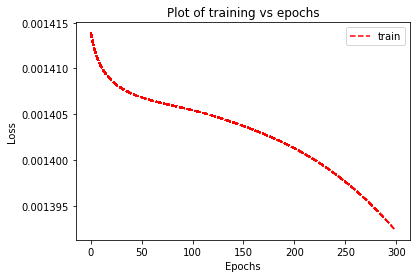

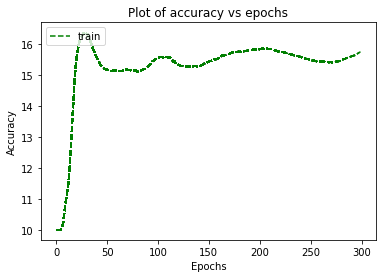

In [ ]:
feat_length = 2+5+2
model = mlp(feat_length).to(device)
criterion = nn.MSELoss()
model = train_model(model, criterion, num_epochs = 300, learning_rate= 10)

### Evaluation of trained model

In [ ]:
# Finding testing accuracy
test_running_corr = 0
# Loading data in batches
batches = 0

model.eval() # Testing the model in evaluation mode

for tsData in tqdm.notebook.tqdm(testLoader):
    inputs,_ = tsData

    inputs = inputs.float().to(device)

    with torch.no_grad(): # No back-propagation during testing; gradient computation is not required

        # Feedforward train data batch through model
        output = model(inputs)
        # Predicted class is the one with maximum probability
        _,preds = output.data.max(1)
        if batches==0:
            totalPreds = preds
            batches = 1
        else:
            totalPreds = torch.cat((totalPreds,preds),0)

ts_corr = np.sum(np.equal(totalPreds.cpu().numpy(),testLabel))
ts_acc = ts_corr/testLabel.shape[0]
print('Testing accuracy = '+str(ts_acc*100)+'%')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.



Testing accuracy = 15.4%
